In [1]:
import numpy as np
import numpy.typing as npt
import os
import matplotlib.pyplot as plt
import seaborn as sns

import frame_whitening as fw
import frame_whitening.data as fwd
import frame_whitening.simulation as fws

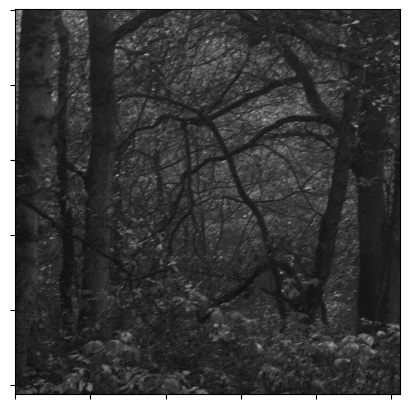

In [2]:
data_dir = "/mnt/home/tyerxa/ceph/datasets/datasets/vanhateren_imc"
files = sorted(os.listdir(data_dir))
seed = 420
rng = np.random.default_rng(seed)

n_images = 10
images = fwd.load_images(n_images=n_images, crop_size=512, rng=rng)

images = [img / np.max(img) for img in images]

img = images[5]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img, cmap="gray")
ax.set(xticklabels=[], yticklabels=[]);

(-0.5, 511.5, 511.5, -0.5)

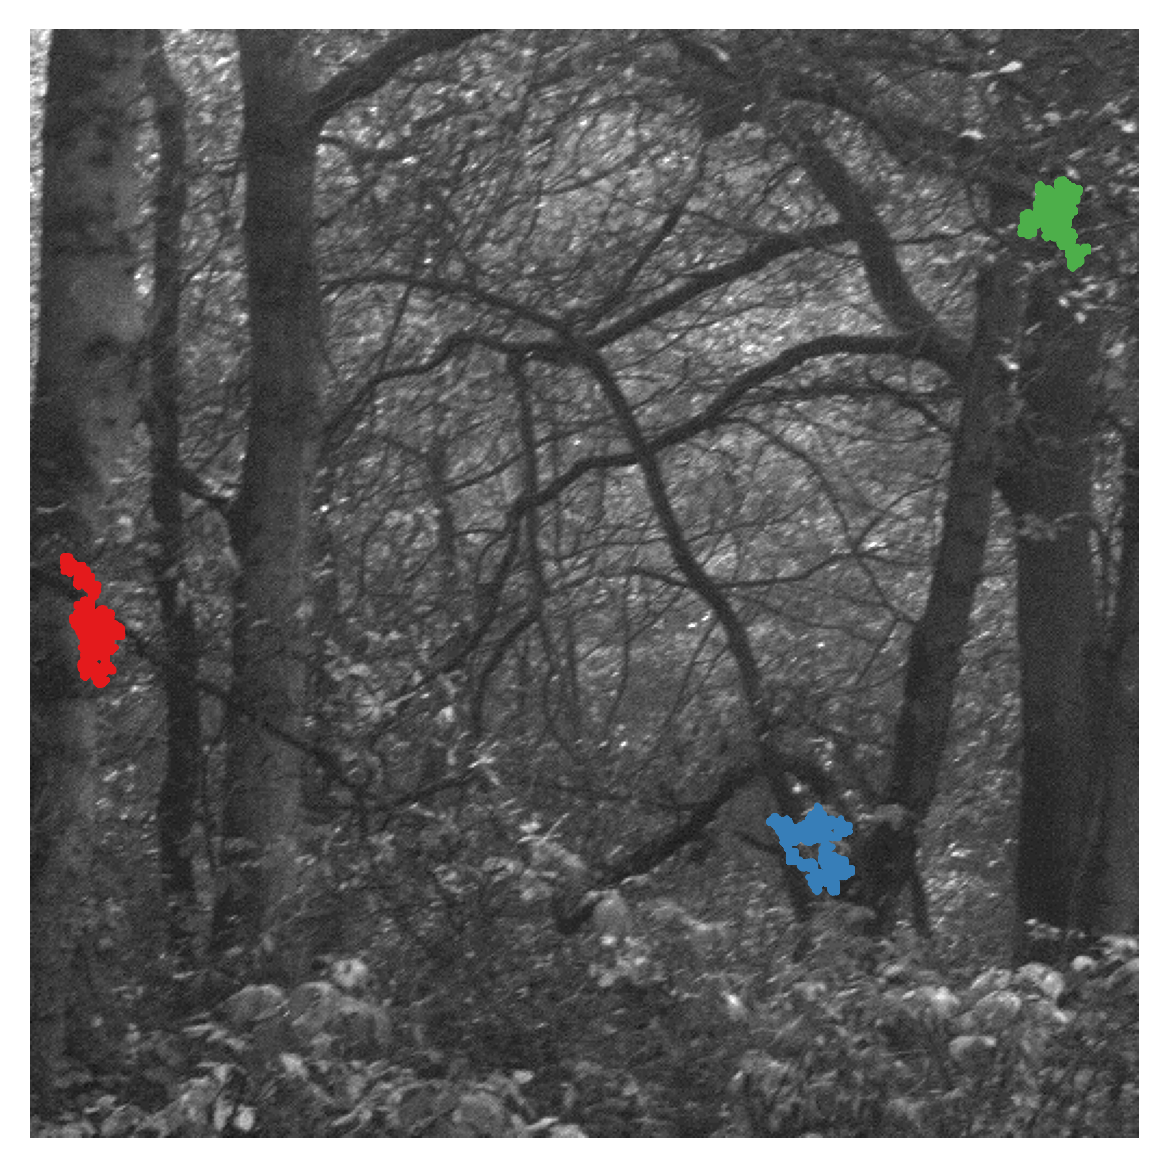

In [31]:
patch_h, patch_w = 12, 12
img_h, img_w = img.shape

sigma = .2
n_steps = 20_000

fig_ctx_walk, ax = plt.subplots(1, 1, dpi=300)
im = ax.imshow(img, cmap="gray", vmin=.02, vmax=.7)

n_contexts = 3
cols = sns.color_palette("Set1", n_contexts)

rng = np.random.default_rng(69)
all_contexts, walk_coords = fwd.get_contexts(img, patch_h, patch_w, n_contexts, sigma, n_steps, pad_factor=1., rng=rng)
for idx, walk_hw in enumerate(walk_coords):
    walk_h, walk_w = walk_hw[:, 0], walk_hw[:, 1]
    ax.plot(walk_h, walk_w, color=cols[idx])
ax.axis("off")

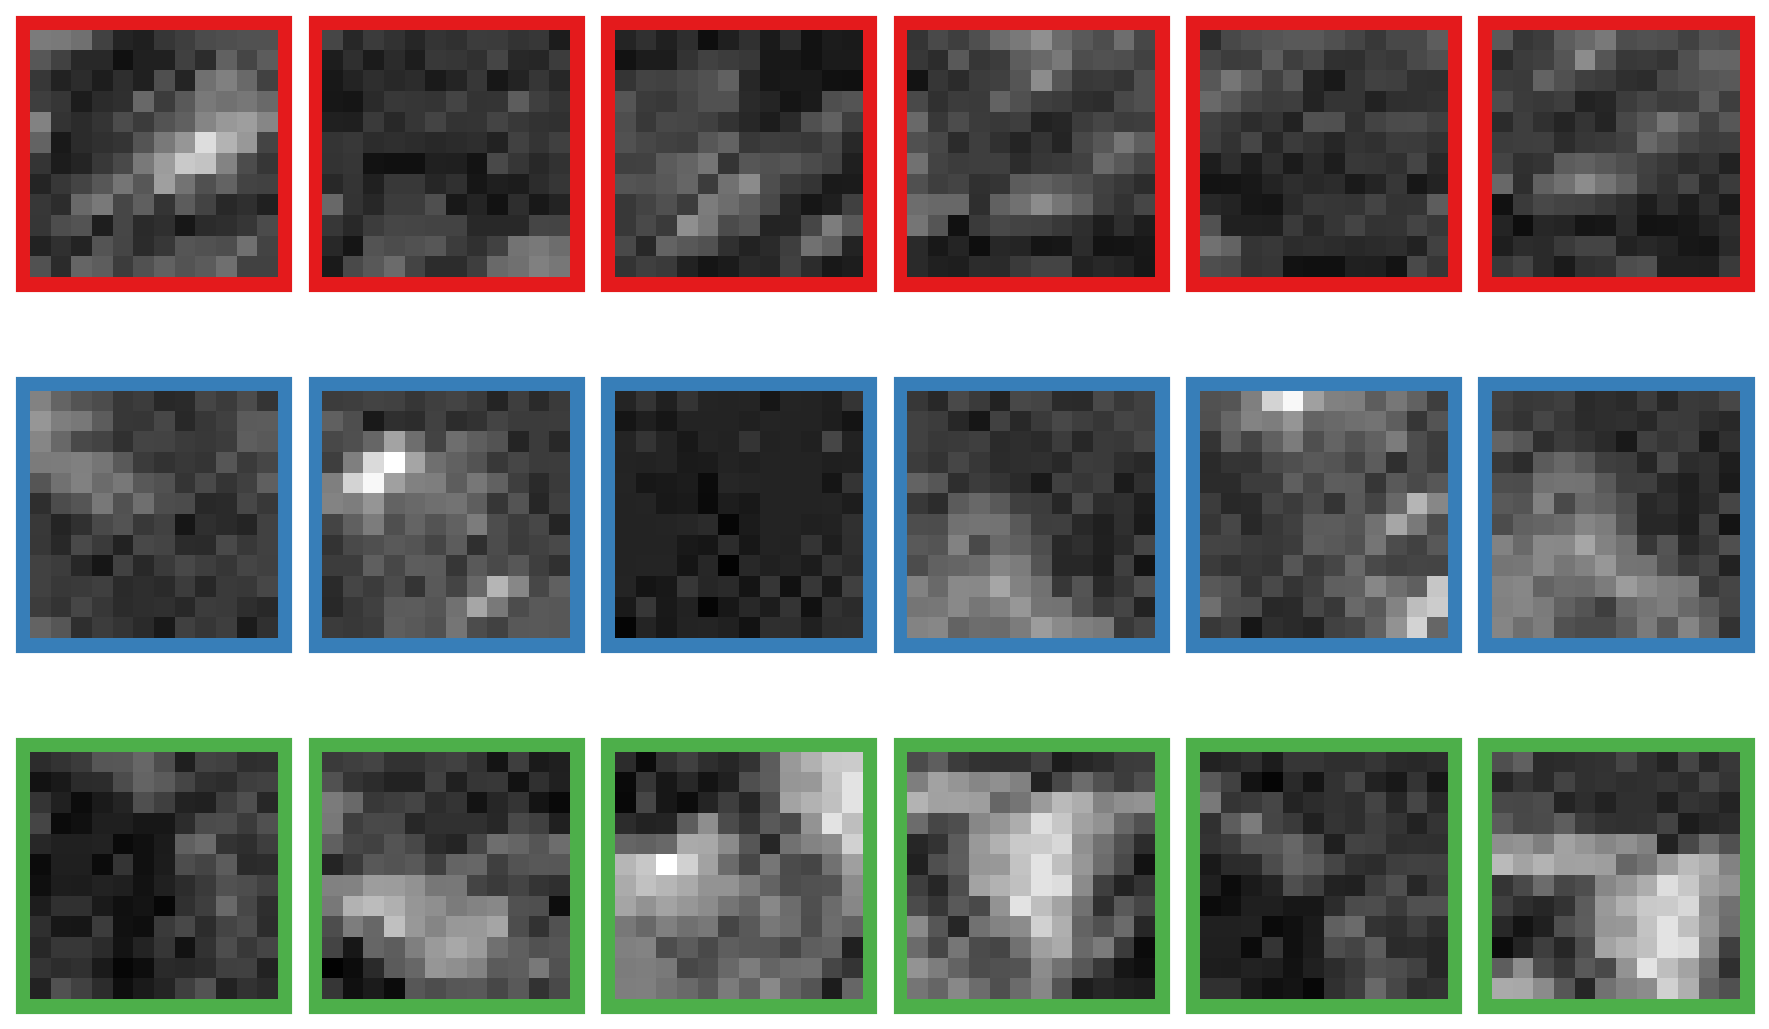

In [32]:
fig_ctx_samples, _ = fwd.plot_context_samples(all_contexts, 6, "gray", "Set1", True, dpi=300)

In [5]:
X = all_contexts[0]
X0 = X.reshape(n_steps, -1)
X0 = X0 - np.mean(X0, axis=0)
X0 = X0 * 16

Cxx0 = np.cov(X0.T)
Cxx = Cxx0 + np.eye(Cxx0.shape[0]) * 1e-4

ll, V = np.linalg.eigh(Cxx)
l12 = 1/np.sqrt(ll)

Mw = V @ np.diag(l12) @ V.T

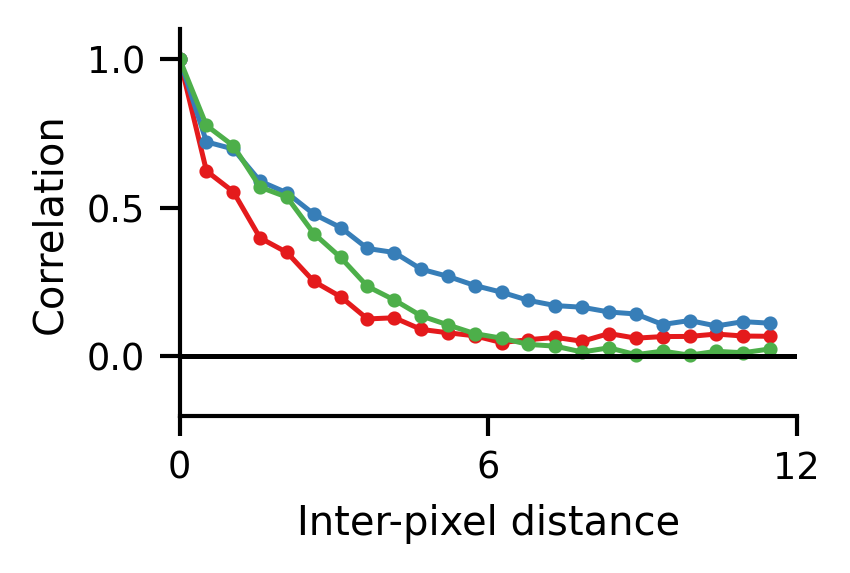

In [28]:
def get_corr_by_dist(X: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    arr = []
    corr0 = np.corrcoef(X.T)

    for i in range(Cxx0.shape[0]):
        for j in range(i, Cxx0.shape[1]):
            id_i = np.unravel_index(i, (patch_h, patch_w))
            id_j = np.unravel_index(j, (patch_h, patch_w))
            distance = np.linalg.norm(np.array(id_i) - np.array(id_j))
            corr = corr0[i, j]
            arr.append((distance, corr))

    dist = np.array(arr)
    return dist

import scipy.stats

with sns.plotting_context("paper"):
    cols = sns.color_palette("Set1", n_contexts)
    fig_ctx_dist, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=300)
    for ctx in range(len(all_contexts)):
        X = all_contexts[ctx]
        X0 = X.reshape(n_steps, -1)
        X0 = X0 - np.mean(X0, axis=0)
        arr = get_corr_by_dist(X0)

        yyy = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=np.linspace(0, patch_h, 2*patch_h), statistic="mean")
        ax.plot(yyy.bin_edges[:-1], yyy.statistic, ".-", color=cols[ctx])

    ax.hlines(0, 0, patch_h, "k")
    ax.set(xlim=(0, patch_h), ylim=(-.2, 1.1), xticks=np.arange(0, patch_h+1, patch_h//2),
    xlabel="Inter-pixel distance", ylabel="Correlation")
    sns.despine()
    fig_ctx_dist.tight_layout()

(144, 2664)


Converged.:  55%|██████████████████████████████████████████████████████████████████████████▉                                                              | 35841/65536 [08:36<07:08, 69.37it/s]


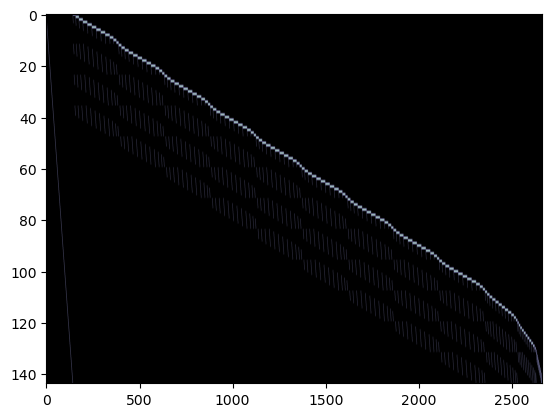

In [7]:
X = all_contexts[0]
X0 = X.reshape(n_steps, -1)
X0 = X0 - np.mean(X0, axis=0)
X0 = X0 * 16
Cxx0 = np.cov(X0.T)
Cxx = Cxx0 + np.eye(Cxx0.shape[0]) * 1e-4

n_batch = 2**16
conv_h, conv_w = 4, 4
W = fw.get_conv_frame(patch_h, patch_w, conv_h, conv_w)
step_skip = 512

# W2 = np.concatenate((W, W3), axis=1)
plt.imshow(W, cmap="bone", aspect="auto")
print(W.shape)

g_last, g_all, _, _ = fws.adapt_covariance(
                                Cxx_list=[Cxx], 
                                W=W, 
                                batch_size=-1, 
                                n_batch=n_batch, 
                                lr_g=2E-2,
                                g0=None,
                                online=False, 
                                clamp=False,
                                alpha=1.,
                                save_every=step_skip,
                            )


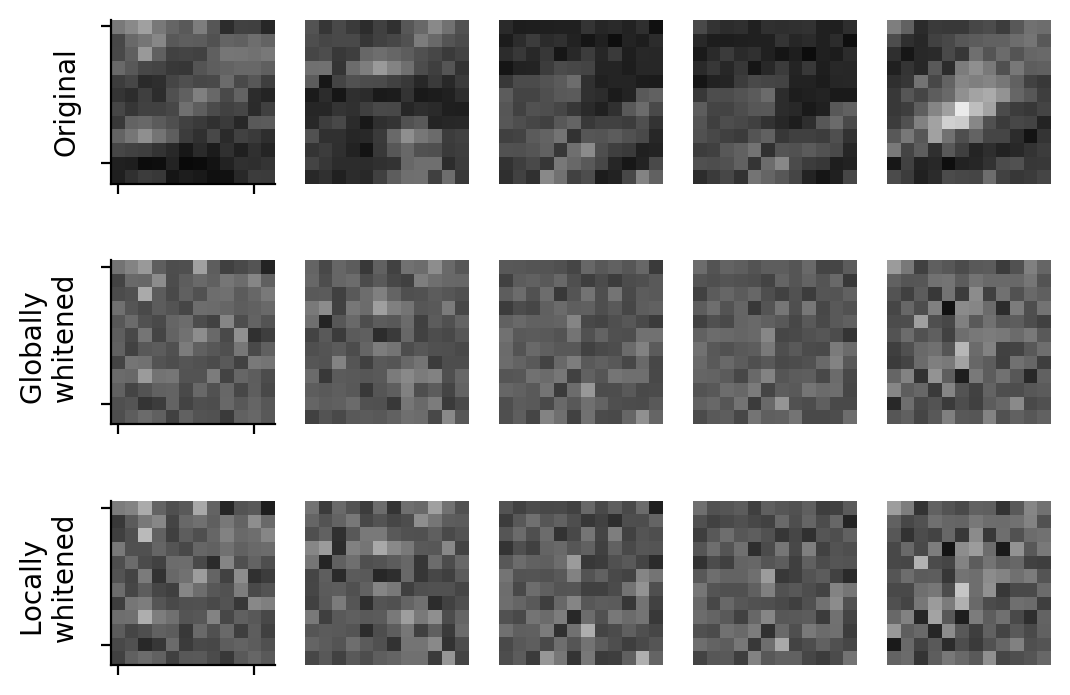

In [8]:
WGW = W @ (g_last[0][:,None] * W.T)
Ixx = np.eye(patch_h * patch_w)
M = np.linalg.inv(Ixx + WGW)
Xw_local = X0 @ M.T
Xw = X0 @ Mw.T

X00 = X0.reshape(n_steps, patch_h, patch_w)
Xw = Xw.reshape(n_steps, patch_h, patch_w)
Xw_local = Xw_local.reshape(n_steps, patch_h, patch_w)

fig, ax = fwd.plot_context_samples(np.stack([X00, Xw, Xw_local], 0), 5, "gray", "Set1", False, dpi=200)
ax[0,0].axis("on")
ax[1,0].axis("on")
ax[2,0].axis("on")

ax[0,0].set(xticklabels=[], yticklabels=[], ylabel="Original")
ax[1,0].set(xticklabels=[], yticklabels=[], ylabel="Globally \n whitened")
ax[2,0].set(xticklabels=[], yticklabels=[], ylabel="Locally \n whitened")
sns.despine()

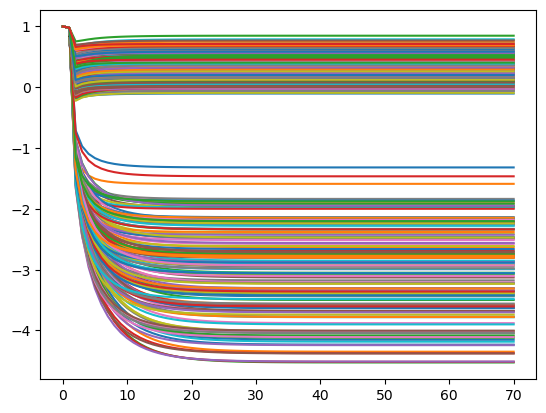

In [9]:
plt.plot(g_all);

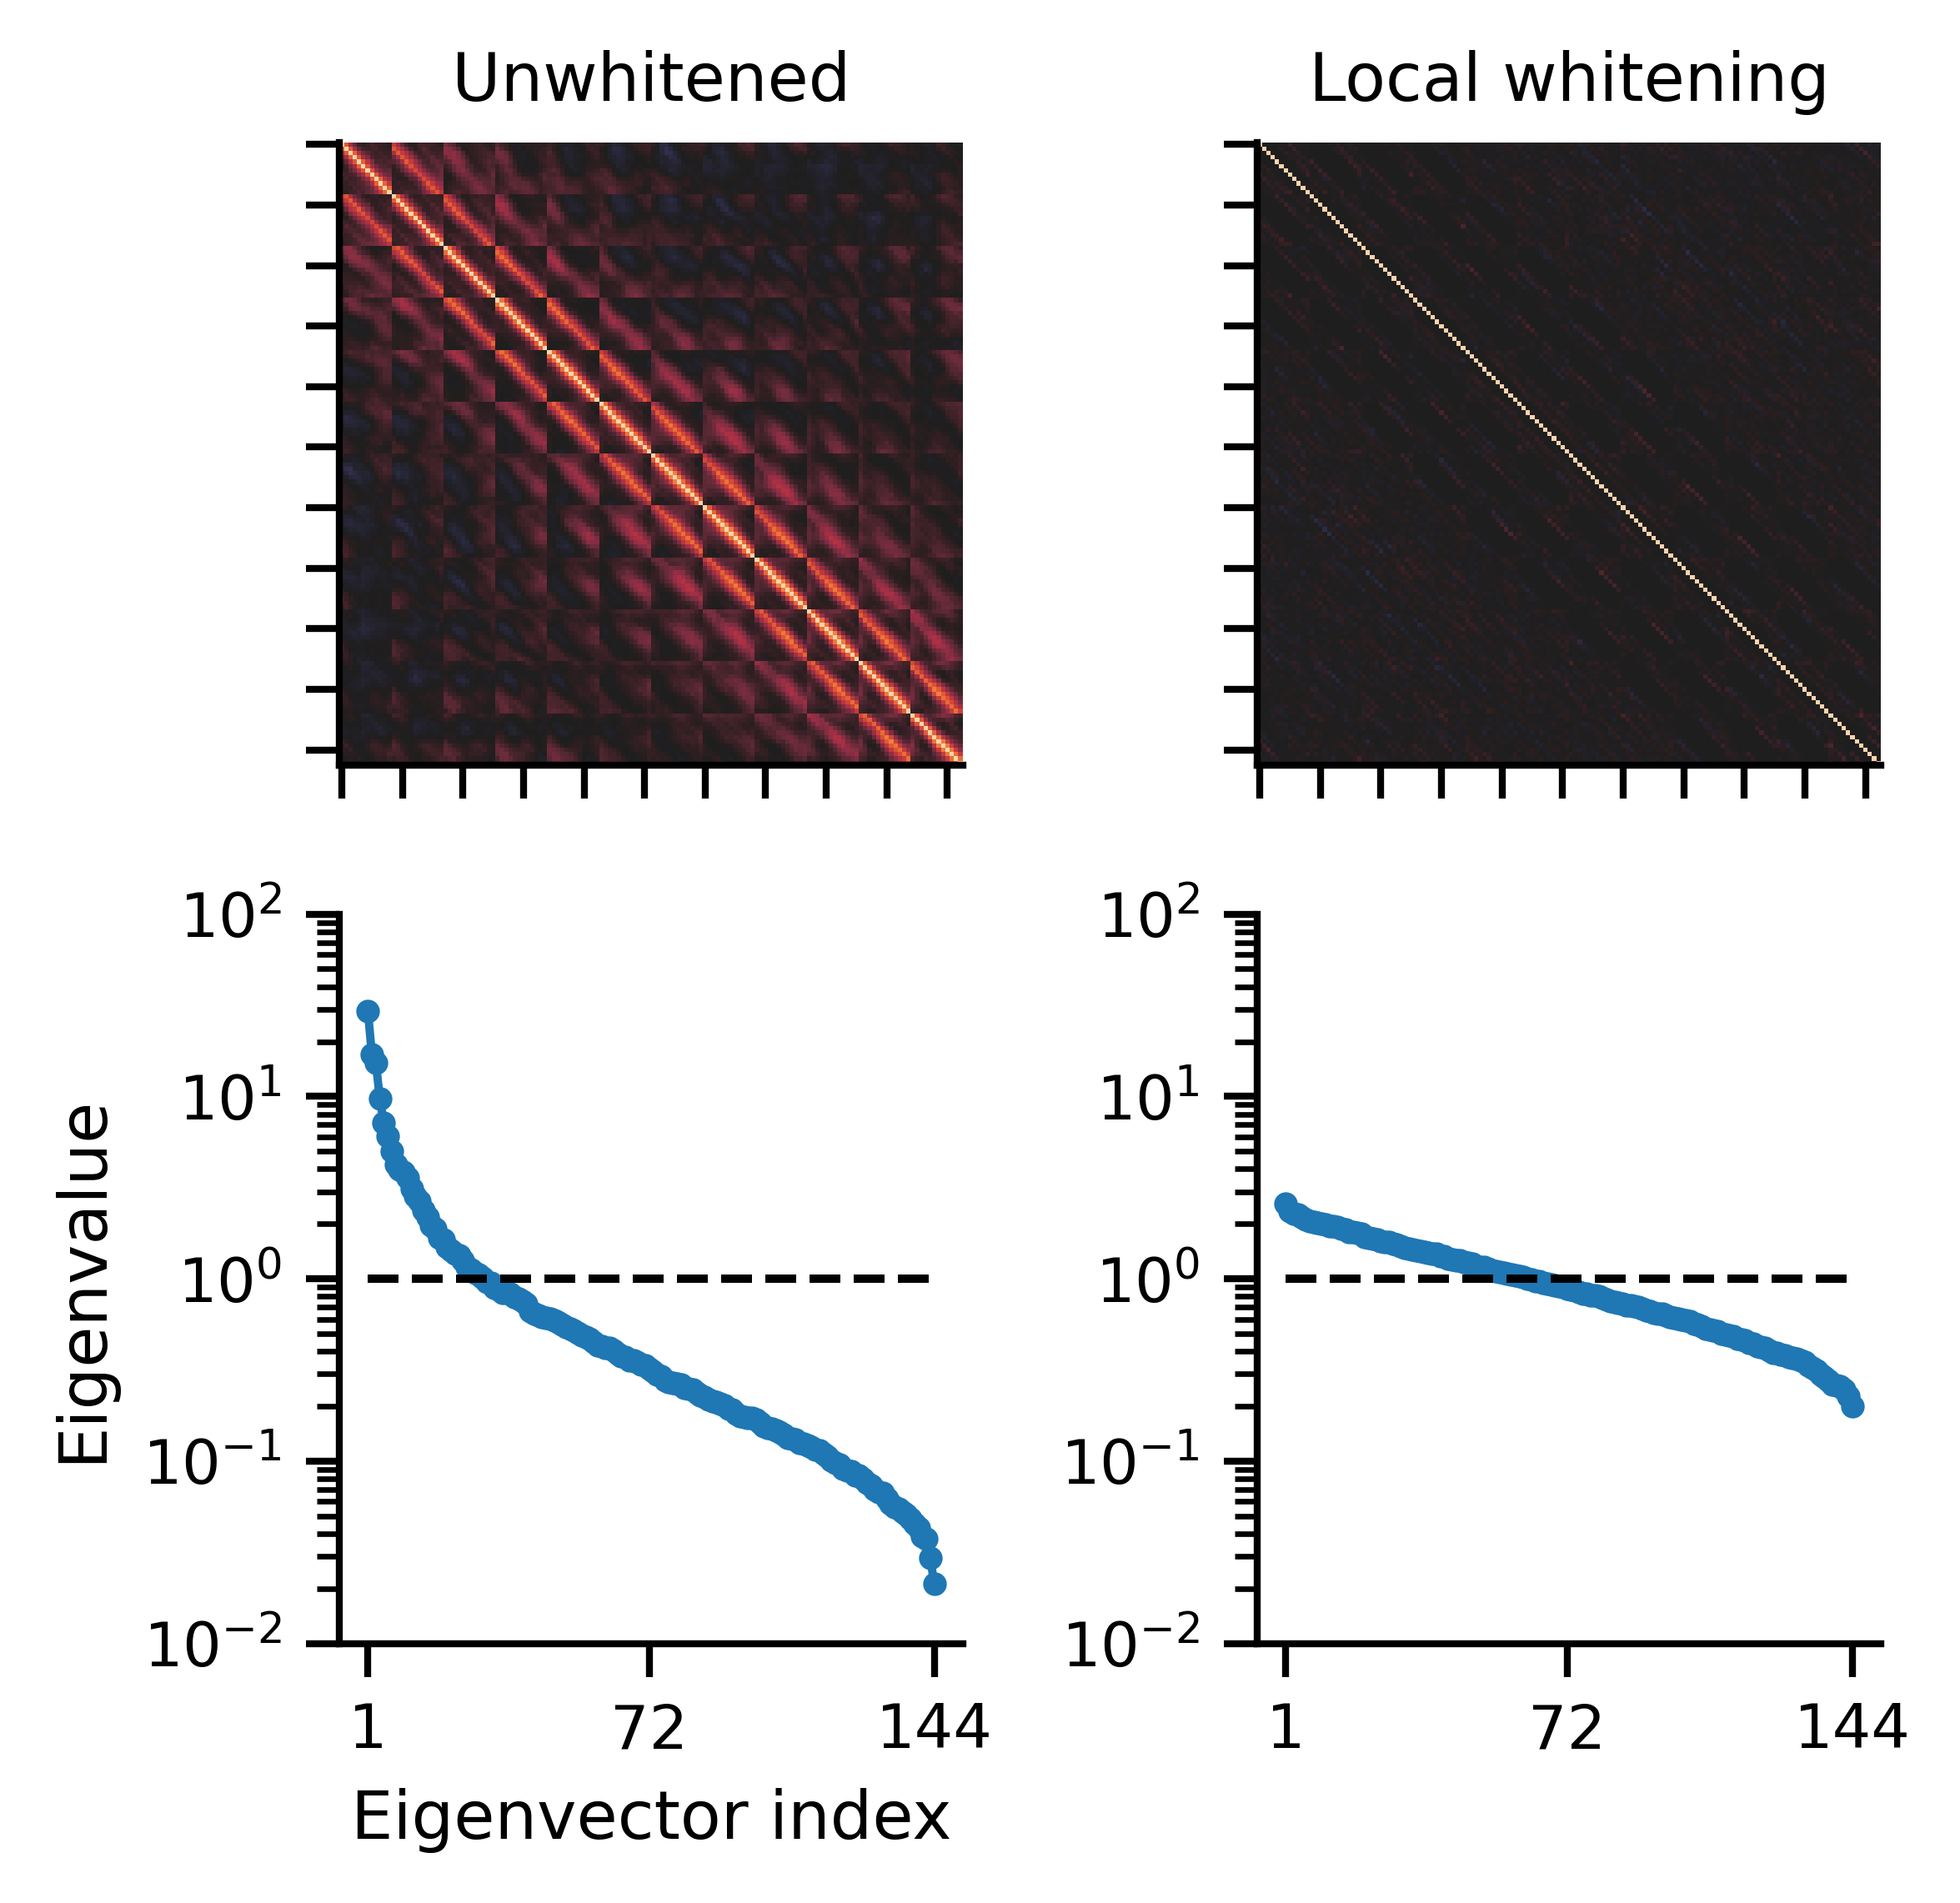

In [26]:
Cw_local = np.cov(Xw_local.reshape(n_steps, -1).T)

ll, V = np.linalg.eigh(Cxx)
l12 = 1/np.sqrt(ll)

Mw = V @ np.diag(l12) @ V.T
Cww = Mw @ Cxx0 @ Mw.T

def heatmap(C, ax, vmax = None, cbar=True):
    if vmax is None:
        _VMAX = np.max(np.abs(C)) 
    else:
        _VMAX = vmax
    im =sns.heatmap(C, ax=ax, vmin=-_VMAX, vmax=_VMAX, cmap="icefire", cbar=cbar, square=True)

def spectrum(C):
    return np.sort(np.abs(np.linalg.eigh(C)[0]))[::-1] + 1E-15

def cov2corr(C):
    D = np.diag(1/np.sqrt(np.diag(C)))
    return D @ C @ D

N = Cxx0.shape[0]

# heatmap(Cxx0, ax[0,0])
# heatmap(Cww, ax[0,1])
# heatmap(Cw_local, ax[0,2])

vmax = np.max(np.abs([cov2corr(Cxx0), cov2corr(Cww), cov2corr(Cw_local)]))
cbar = False

with sns.plotting_context('paper'):
    fig_spectrum, ax = plt.subplots(2, 2, figsize=(4, 4), dpi=600, sharex="row")
    heatmap(cov2corr(Cxx0), ax[0,0], vmax, cbar)
    # heatmap(cov2corr(Cww), ax[0,1], vmax, cbar)
    heatmap(cov2corr(Cw_local), ax[0,1], vmax, cbar)

    ax[1,0].plot(np.arange(1,N+1), spectrum(Cxx0), ".-")
    # ax[1,1].plot(np.arange(1, N+1), spectrum(Cww), ".-")
    ax[1,1].plot(np.arange(1, N+1), spectrum(Cw_local), ".-")

    ax[1,0].hlines(1, 1, N, color="k", linestyle="--")
    # ax[1,1].hlines(1, 1, N, color="k", linestyle="--")
    ax[1,1].hlines(1, 1, N, color="k", linestyle="--")

    ax[0,0].set(title='Unwhitened', xticklabels=[], yticklabels=[])
    # ax[0,1].set(title='Global whitening', xticklabels=[], yticklabels=[])
    ax[0,1].set(title='Local whitening', xticklabels=[], yticklabels=[])

    yscale = "log"
    _YMIN, _YMAX = 1E-2, 100
    ax[1, 0].set( yscale=yscale, 
        ylabel="Eigenvalue", xlabel="Eigenvector index",
        xticks=(1, N//2, N), xticklabels=(1, N//2, N), ylim=(_YMIN, _YMAX))

    # ax[1, 1].set( yscale=yscale, ylim=(_YMIN, _YMAX))
    ax[1, 1].set( yscale=yscale, ylim=(_YMIN, _YMAX))

    fig_spectrum.tight_layout()
    sns.despine()

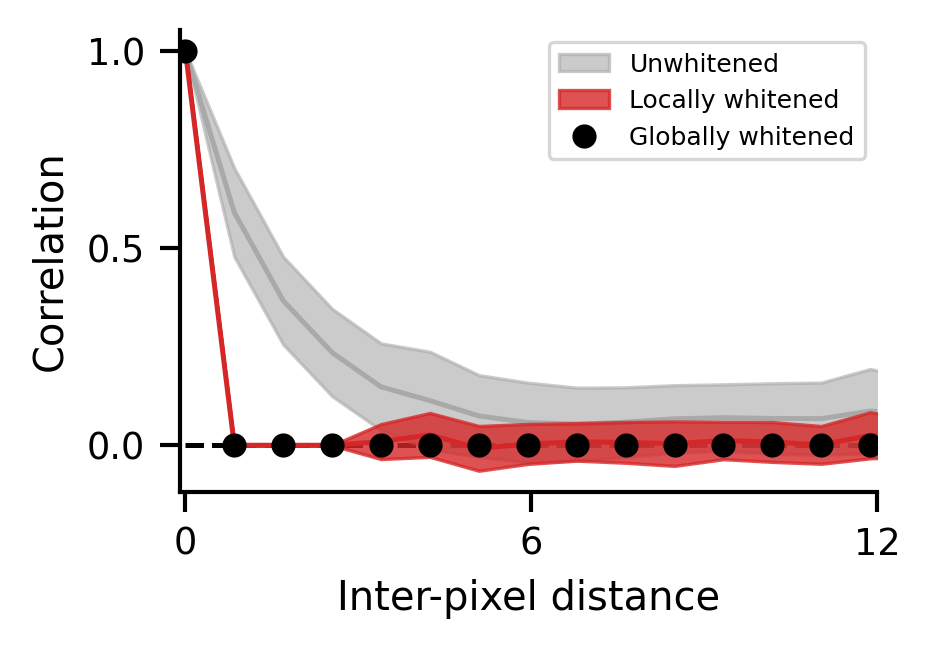

In [25]:
_XMAX = np.sqrt(patch_h**2 + patch_w**2)
bins = np.linspace(0, _XMAX, 21)
# bins = np.linspace(0, 2*patch_h, 21)

def plot_corr_by_dist(X, ax, statistic="std",**kwargs):
    arr = get_corr_by_dist(X)
    yyy = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=bins, statistic="mean")
    x = yyy.bin_edges[:-1]
    mu = yyy.statistic
    if statistic == "std":
        zzz = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=bins, statistic= "std")
        lo = yyy.statistic - zzz.statistic
        hi = yyy.statistic + zzz.statistic
    else:
        lo = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=bins, statistic= "min").statistic
        hi = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=bins, statistic= "max").statistic

    ax.fill_between(x, lo, hi, yyy.statistic, **kwargs)
    return x, mu, hi, lo


statistic = "std"
with sns.plotting_context("paper", font_scale=1):
    fig_autocorr, ax = plt.subplots(1, 1, dpi=300, figsize=(3, 2))
    x, mu_unwhitened, _, _ =plot_corr_by_dist(X0, ax, statistic, **{"label": "Unwhitened", "color": "darkgrey", "alpha":0.6})
    ax.plot(x, mu_unwhitened, color="darkgrey", zorder=-1)

    x, mu_local, _, _ = plot_corr_by_dist(X0 @ M.T, ax, statistic, **{"label": "Locally whitened", "color": "C3", "alpha":0.8})
    ax.plot(x, mu_local, "C3")

    arr = get_corr_by_dist(X0 @ Mw.T)
    yyy = scipy.stats.binned_statistic(arr[:, 0], arr[:, 1], bins=bins, statistic="mean")
    ax.plot(x, yyy.statistic, "ok", label="Globally whitened", lw=.5)
    ax.hlines(0, 0, np.sqrt(patch_h**2 + patch_w**2), color="k", linestyle="--", zorder=-1)

    ax.legend(fontsize=6)
    ax.set(xlabel="Inter-pixel distance", ylabel="Correlation", xlim=(-.1, 12), 
    yticks=(0, .5, 1),
    xticks = np.arange(0, patch_h+1, patch_h//2)
    # xticks=(0, x[-2]//2, np.round(x[-3]))
    )
    sns.despine()

In [29]:
# save multipage pdf
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages("figures/icml2023/6_conv2d.pdf") as pdf:
    pdf.savefig(fig_ctx_dist, bbox_inches="tight")
    pdf.savefig(fig_autocorr, bbox_inches="tight")
    pdf.savefig(fig_spectrum, bbox_inches="tight")

Multiscale kernel

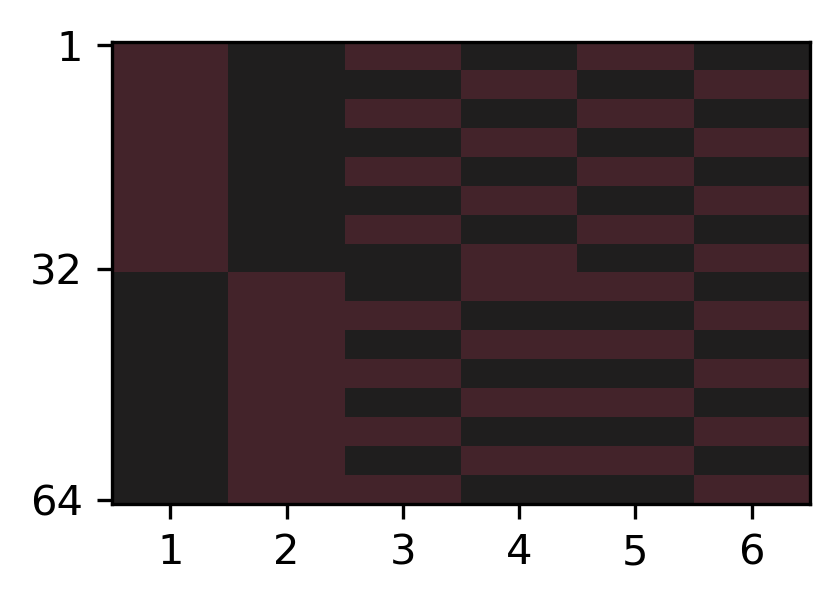

In [12]:
# W3 = np.zeros((64, 6))
# nnn = 64

# W3[:32,0] = 1
# W3[:, 1] = np.roll(W3[:, 0], 32)
# W3[:, 3] = np.roll(W3[:, 0], -16)
# W3[[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27], 4] = 1
# W3[[32, 33, 34, 35, 40, 41, 42, 43, 48, 49, 50, 51, 56, 57, 58, 59], 4] = 1
# W3[:, 5] = np.roll(W3[:, 4], 4)
# W3[:, 2] = np.concatenate((W3[:32, 4], W3[32:, 5]))
# W3[:, 3] = np.concatenate((W3[:32, 5], W3[32:, 4]))
# W3 = W3 / np.sqrt(32)

# fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=300)
# ax.imshow(W3, aspect="auto", interpolation="none", cmap=sns.color_palette("icefire", as_cmap=True), vmin=-1, vmax=1)
# ax.set(yticks=(0, 31, 63), yticklabels=(1, 32, 64), xticks=(0, 1, 2, 3, 4, 5), xticklabels=(1, 2, 3, 4, 5, 6));